<a href="https://colab.research.google.com/github/ThisuriLekamge/NeuralStyleTransfer_PyTorch/blob/master/NeuralStyleTransfer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from __future__ import print_function

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from PIL import Image
import matplotlib.pyplot as plt

import torchvision.transforms as transforms
import torchvision.models as models

import copy #to copy the deep models and packages

In [0]:
from google.colab import files
picasso = files.upload()

Saving picasso.jpg to picasso.jpg


In [0]:
from google.colab import files
dancer = files.upload()

Saving dancing.jpg to dancing.jpg


In [0]:
imsize = 512

loader = transforms.Compose([
                             transforms.Resize(imsize),
                             transforms.ToTensor()
])

def image_loader(image_name):
  image = Image.open(image_name)
  print(image.size)
  image = loader(image).unsqueeze(0)
  print(image)
  print(image.size())
  return image

style_img = image_loader("./picasso.jpg")
content_img = image_loader("./dancing.jpg")

assert style_img.size() == content_img.size()


(650, 650)
tensor([[[[0.1882, 0.1608, 0.1490,  ..., 0.3843, 0.3647, 0.3765],
          [0.1529, 0.1412, 0.1333,  ..., 0.3647, 0.3608, 0.3725],
          [0.1373, 0.1490, 0.1490,  ..., 0.3882, 0.3725, 0.3725],
          ...,
          [0.1451, 0.1608, 0.1647,  ..., 0.1333, 0.1373, 0.1373],
          [0.1412, 0.1608, 0.1686,  ..., 0.1294, 0.1294, 0.1255],
          [0.1451, 0.1725, 0.1765,  ..., 0.1294, 0.1176, 0.1137]],

         [[0.2667, 0.2392, 0.2275,  ..., 0.4157, 0.3961, 0.4039],
          [0.2314, 0.2196, 0.2118,  ..., 0.3961, 0.3882, 0.4000],
          [0.2157, 0.2275, 0.2275,  ..., 0.4196, 0.4000, 0.3961],
          ...,
          [0.2157, 0.2314, 0.2353,  ..., 0.1882, 0.1922, 0.1922],
          [0.2118, 0.2314, 0.2392,  ..., 0.1922, 0.1882, 0.1843],
          [0.2078, 0.2353, 0.2392,  ..., 0.1922, 0.1804, 0.1765]],

         [[0.2980, 0.2745, 0.2627,  ..., 0.3725, 0.3529, 0.3608],
          [0.2588, 0.2510, 0.2471,  ..., 0.3529, 0.3451, 0.3569],
          [0.2431, 0.2549, 0.26

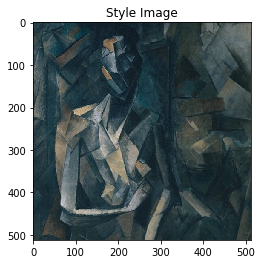

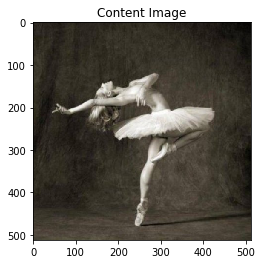

In [0]:
# to ensure 
unloader = transforms.ToPILImage()
plt.ion()

def imshow(tensor, title=None):
  image = tensor.cpu().clone()
  image = image.squeeze(0)
  image = unloader(image)
  plt.imshow(image)
  if title is not None:
    plt.title(title)
  plt.pause(0.001)

plt.figure()
imshow(style_img, title="Style Image")

plt.figure()
imshow(content_img, title="Content Image")




In [0]:
class ContentLoss(nn.Module):

  def __init__(self, target):
    super(ContentLoss, self).__init__()
    self.target = target.detach()

  def forward(self, input):
    self.loss = F.mse_loss(input, self.target)
    return input


In [0]:
def gram_matrix(input):
  a,b,c,d = input.size()
  features = input.view(a*b, c*d)
  G = torch.mm(features, features.t())
  return G.div(a*b*c*d)


In [0]:
class StyleLoss(nn.Module):
  def __init__(self,target_feature):
    super(StyleLoss, self).__init__()
    self.target = gram_matrix(target_feature).detach()

  def forward(self, input):
    G = gram_matrix(input)
    self.loss = F.mse_loss(G, self.target)
    return input

In [0]:
cnn = models.vgg19(pretrained=True).eval()

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:08<00:00, 64.1MB/s]


In [0]:
cnn_normz_mean  = torch.tensor([0.485,0.456,0.406])
cnn_normz_std = torch.tensor([0.229,0.224,0.225])

class Normalization(nn.Module):
  def __init__(self, mean, std):
    super(Normalization, self).__init__()
    self.mean = torch.tensor(mean).view(-1,1,1)
    self.std = torch.tensor(std).view(-1,1,1)

  def forward(self,img):
    return (img - self.mean)/self.std
